In [2]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.signal import find_peaks, peak_prominences
import bottleneck as bn

In [3]:
d4 = pd.read_csv('data/battery_data/2020-4.csv', index_col='timestamp')
d5 = pd.read_csv('data/battery_data/2020-5.csv', index_col='timestamp')
d6 = pd.read_csv('data/battery_data/2020-6.csv', index_col='timestamp')
d7 = pd.read_csv('data/battery_data/2020-7.csv', index_col='timestamp')
d8 = pd.read_csv('data/battery_data/2020-8.csv', index_col='timestamp')
d9 = pd.read_csv('data/battery_data/2020-9.csv', index_col='timestamp')

/home/iross/.conda/envs/challenge-1/lib/python3.9/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
d4.index = pd.to_datetime(d4.index, unit='s')
d5.index = pd.to_datetime(d5.index, unit='s')
d6.index = pd.to_datetime(d6.index, unit='s')
d7.index = pd.to_datetime(d7.index, unit='s')
d8.index = pd.to_datetime(d8.index, unit='s')
d9.index = pd.to_datetime(d9.index, unit='s')

In [5]:
d = d4
d = d.append(d5)
d = d.append(d6)
d = d.append(d7)
d = d.append(d8)
d = d.append(d9)

<IPython.core.display.Javascript object>


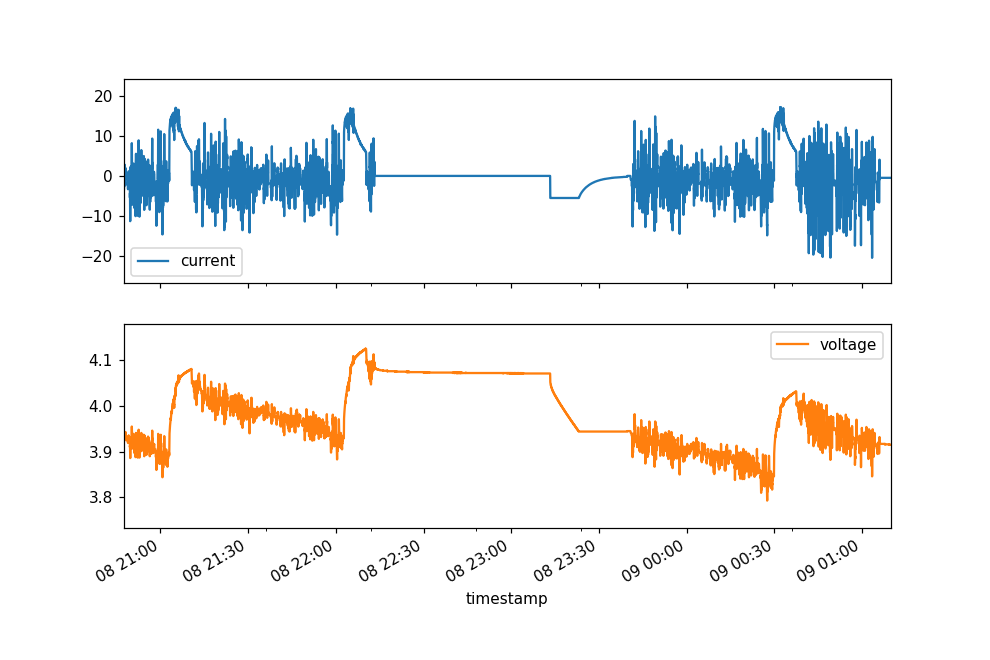

array([<AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>],
      dtype=object)

In [5]:
d[['current','voltage']].plot(subplots=True, figsize=(9,6))

In [6]:
peaks, _ = find_peaks(d.voltage, height=4.12, width=30, prominence=0.05, distance=150)
plateaus = np.zeros_like(peaks)
starts = np.zeros_like(peaks)

search_window = 3 * 3600 # 3 hours
min_plateau = 10 * 60 # 10 minutes

for i in range(peaks.size):
    p = peaks[i]
    print(d.index[p], d.voltage[p])
    
    search = p
    while search < p + search_window and d.voltage[search] > 4.0:
        search += 1
    
    if d.voltage[search] > 4.0:
        continue
            
    plat = search
    v_plat = d.voltage[plat]
    
    flat = False
    while not flat:
        if d.voltage[plat] < 3.8 or d.voltage[plat] > v_plat + 0.01:
            break
            
        if d.voltage[plat + 1] < v_plat or d.voltage[plat + 20] < v_plat:
            plat += 1
            v_plat = d.voltage[plat]
        else:
            flat = True
            
    if not flat:
        continue
            
    ok = True
    for check in range(min_plateau):
        if abs(d.voltage[plat + check] - v_plat) > 0.01:
            ok = False
            break
        
    if ok:
        print("  OK")
        plateaus[i] = plat
        s = plat
        while s > p and d.current[s] != 0:
            s -= 1
        starts[i] = s


2020-04-01 04:05:50 4.129
2020-04-01 08:59:34 4.15
2020-04-01 17:38:45 4.148
2020-04-02 02:19:43 4.148
2020-04-03 02:31:08 4.123
  OK
2020-04-03 19:58:07 4.126
  OK
2020-04-04 13:25:37 4.127
  OK
2020-04-05 06:53:21 4.126
  OK
2020-04-06 00:20:17 4.125
  OK
2020-04-06 17:47:49 4.125
  OK
2020-04-07 11:15:15 4.125
  OK
2020-04-08 04:42:43 4.125
  OK
2020-04-08 22:10:08 4.125
  OK
2020-04-09 15:37:20 4.125
  OK
2020-04-10 09:04:39 4.125
  OK
2020-04-11 02:32:13 4.125
  OK
2020-04-11 19:59:31 4.125
  OK
2020-04-12 13:26:59 4.126
  OK
2020-04-13 06:54:06 4.125
  OK
2020-04-14 00:21:40 4.126
  OK
2020-04-14 17:49:02 4.125
  OK
2020-04-15 11:16:27 4.126
  OK
2020-04-16 04:43:58 4.126
  OK
2020-04-16 22:11:13 4.125
  OK
2020-04-17 15:38:31 4.126
  OK
2020-04-18 09:06:01 4.127
  OK
2020-04-19 02:33:24 4.126
  OK
2020-04-19 20:00:52 4.126
  OK
2020-04-20 13:28:18 4.125
  OK
2020-04-21 06:55:20 4.126
  OK
2020-04-22 00:22:35 4.126
  OK
2020-04-22 17:49:59 4.126
  OK
2020-04-23 11:17:11 4.126
  O

In [7]:
peaks = peaks[plateaus != 0]
starts = starts[plateaus != 0]
plateaus = plateaus[plateaus != 0]

<IPython.core.display.Javascript object>


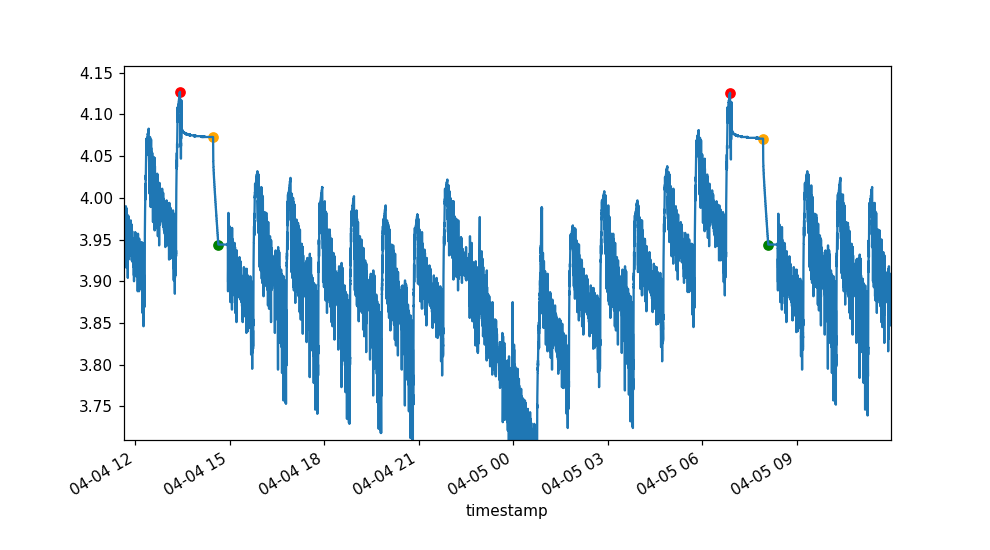

<AxesSubplot:xlabel='timestamp'>

In [17]:
plt.scatter(d.index[peaks], d.voltage[peaks], color='red')
plt.scatter(d.index[plateaus], d.voltage[plateaus], color='green')
plt.scatter(d.index[starts], d.voltage[starts], color='orange')
d.voltage.plot(figsize=(9,5))

In [8]:
discharge = pd.DataFrame({'timestamp': d.index[peaks], 'duration': plateaus - starts })
discharge.index = discharge.timestamp

<IPython.core.display.Javascript object>


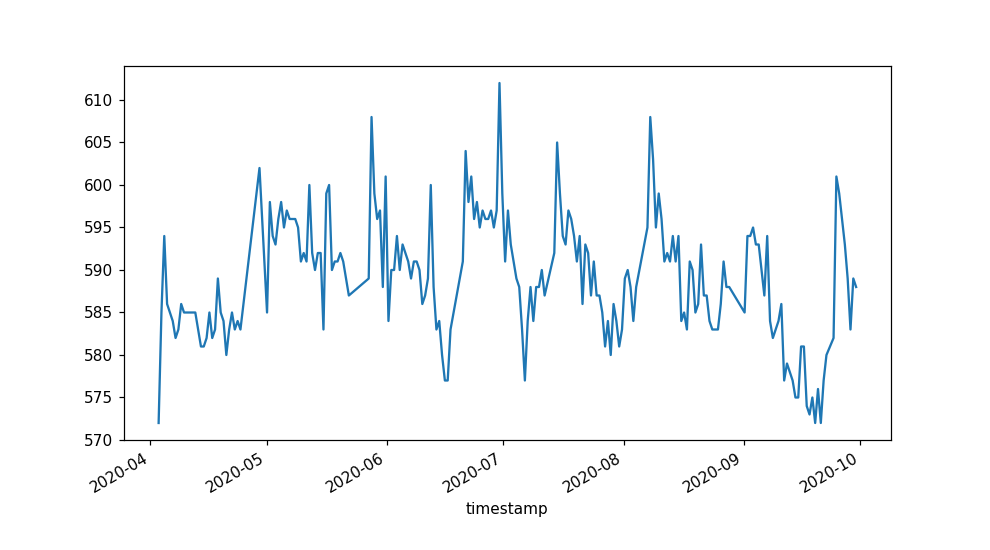

<AxesSubplot:xlabel='timestamp'>

In [9]:
discharge.duration.plot(figsize=(9,5))

In [10]:
rate = pd.DataFrame({'timestamp': d.index[peaks],
                     'dvdt': (d.voltage[starts].values - d.voltage[plateaus].values) / (plateaus - starts) })
rate.index = rate.timestamp

In [11]:
rate['smoothed'] = savgol_filter(rate.dvdt, 51, 1)

In [26]:
refc = pd.read_csv('data/testbench_results/testbench_results_first3months.csv')
refc.index = pd.to_datetime(refc.timestamp, unit='s')

In [27]:
refc

,timestamp,Q_discharge
timestamp,,
2020-04-01 08:49:50,1.585731e+09,-11.403694
2020-04-24 07:14:18,1.587712e+09,-11.341753
2020-05-22 05:56:22,1.590127e+09,-11.307378
2020-06-17 10:59:20,1.592392e+09,-11.277411


<IPython.core.display.Javascript object>


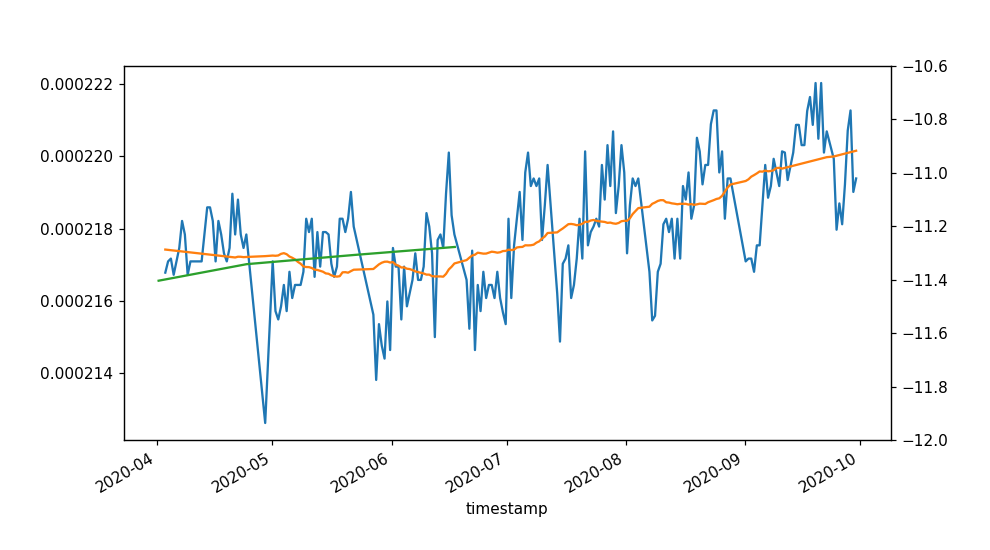

(-12.0, -10.6)

In [44]:
ax = rate.dvdt.plot(figsize=(9,5))
rate.smoothed.plot()
refc.Q_discharge.plot(secondary_y=True)
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim((-12,-10.6))

In [45]:
predict_dates = pd.Series(['2020-07-11', '2020-08-04', '2020-08-28', '2020-09-22', '2020-10-01'])
predict = pd.DataFrame(index=predict_dates, columns=['capacity'])


In [46]:
predict

,capacity
2020-07-11,NaN
2020-08-04,NaN
2020-08-28,NaN
2020-09-22,NaN
2020-10-01,NaN
